# MT Data-conditioned VAE

In [1]:
# pip install tensorflow

In [2]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
from scipy import interpolate
# import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

In [3]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [4]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 32*0.3048
depth_to_top = 32*0.3048
n_cells = 32
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
times = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055])*1e-3
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(times)
print(nt)
# data are only real
ndata = nt

29
15


In [5]:
depths=np.append(depths,[554,573])
print(depths.shape)

(31,)


In [6]:
times = np.append(times,16.055*1e-3)
print(len(times))

16


In [7]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [8]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
                   data_std=0.1,
                   model_std=.01,
                   beta_vae=4,
                   model_loss_type='se',
                   data_loss_type='se'
                  )


thicknesses (31,)


c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [9]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

x_train_log = preprocess('Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test1_log = preprocess('Line2_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')
# print(x_train_log)

x_train_raw = np.load('Line1_Central_Observations.npy')
x_validate_raw = np.load('Line3_Central_Observations.npy')
x_test1_raw = np.load('Line2_Central_Observations.npy')
#print(x_train_raw_log)

# x_train_raw = network.model_to_tanhs(x_train_raw_log)
# x_validate_raw = network.model_to_tanhs(x_validate_raw_log)
# x_test1_raw = network.model_to_tanhs(x_test1_raw_log)
# print(x_train_raw)

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test1 = network.model_to_tanhs(x_test1_log)
# x_test2 = network.model_to_tanhs(x_test2_log)
# print(x_train)
# print(np.max(x_train))

In [10]:
x_train1 = x_train[0:1000,]
x_validate1 = x_validate[0:1000,]
x_train_raw1 = x_train_raw[0:1000,]
x_validate_raw1 = x_validate_raw[0:1000,]
x_test_raw1 = x_test1_raw[0:1000,]
# plt.plot(x_train_raw1[0],np.append(0,depths))

In [11]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = x_train1[:,:,0]
print(train_data)
print("train data", train_data.shape)
print('.........')

raw_train_data = -x_train_raw1
# log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("raw_train_data", raw_train_data.shape)
print(raw_train_data)
validate_data = x_validate1[:,:,0]
raw_validate_data = x_validate_raw1

# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

[[-0.3717506  -0.35877268 -0.33019401 ... -0.5399025  -0.53984124
  -0.53986997]
 [-0.35924058 -0.3459848  -0.3168738  ... -0.53991749 -0.53985802
  -0.53988592]
 [-0.34984667 -0.33582953 -0.30524038 ... -0.53992124 -0.53986095
  -0.53988923]
 ...
 [-0.17945237 -0.15864629 -0.12139163 ... -0.53989797 -0.53986838
  -0.53988226]
 [-0.17917573 -0.1583147  -0.12093393 ... -0.5398954  -0.53986531
  -0.53987942]
 [-0.17774358 -0.15715603 -0.12023772 ... -0.53989532 -0.53986605
  -0.53987978]]
train data (1000, 32)
.........
raw_train_data (1000, 16)
[[-7.947291 -7.020374 -6.58563  ... -0.582863 -0.272842 -0.272842]
 [-7.903422 -6.97731  -6.545748 ... -0.579572 -0.271219 -0.271219]
 [-7.858701 -6.934481 -6.506257 ... -0.576283 -0.269532 -0.269532]
 ...
 [-8.692881 -7.881269 -7.458712 ... -0.610495 -0.270002 -0.270002]
 [-8.713656 -7.898522 -7.477573 ... -0.616137 -0.273557 -0.273557]
 [-8.745406 -7.926272 -7.506173 ... -0.622007 -0.277042 -0.277042]]


In [12]:
# plt.plot(train_data[0],np.append(0,depths))
# plt.plot(obs1_new[0], np.append(0,depths), color='red')

In [13]:
# np.save('train_data.npy',train_data)
# np.save('raw_train_data.npy',raw_train_data)
# np.save('validate_data.npy',validate_data)
# np.save('raw_validate_data.npy',raw_validate_data)

In [14]:
# train_data = np.load('train_data.npy')
# raw_train_data = np.load('raw_train_data.npy')
# validate_data = np.load('validate_data.npy')
# raw_validate_data = np.load('raw_validate_data.npy')
print(train_data.shape)
print(raw_train_data.shape)

# plt.plot(x_train1[0],np.append(0,depths))
# plt.plot(train_data[0],np.append(0,depths))

(1000, 32)
(1000, 16)


In [15]:
# # Create batches and shuffle
BATCH_SIZE = 10

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_data, tf.float32), 
    tf.cast(raw_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(validate_data, tf.float32),
    tf.cast(raw_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data, axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
# print(mean_model_value, rel_model_std)
# print(rel_data_std, model_std_vec)

In [16]:
# plt.plot(train_dataset[0],np.append(0,depths))

In [17]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=1,
                   model_loss_type='se',
                   data_loss_type='se'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

thicknesses (31,)


"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [18]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, 32))
# print('i_random_train',i_random_train)
# print('random_train',random_train)
print(network.predict_tanh(random_train))
# predict their data
# print(n_cells)
random_data = network.predict_tanh(random_train.reshape(16, 32, 1))
# print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
# print('random_log_data', random_log_data)
print('random_data',random_data)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
# print(latent_input)
# print('n_data',network.n_data)
random_data1 = random_data[:,:16]
data_input = tf.reshape(random_data1,(16,network.n_time))
print('data_input',data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
print('zd_input',zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

nb 16
ys_test (16,)
tf.Tensor(
[[-6.45190674e+02 -1.99556885e+02 -1.22700432e+02 -8.18726120e+01
  -5.61505432e+01 -3.98589859e+01 -2.82299423e+01 -1.95049419e+01
  -1.28353300e+01 -8.12762451e+00 -5.14624023e+00 -3.17465830e+00
  -1.73849249e+00 -8.02676141e-01 -2.78712511e-01 -2.78712511e-01]
 [-6.60474548e+02 -2.04724487e+02 -1.25295021e+02 -8.33827133e+01
  -5.71352615e+01 -4.05631981e+01 -2.87305698e+01 -1.98522739e+01
  -1.30706110e+01 -8.28317356e+00 -5.24601698e+00 -3.23317933e+00
  -1.76740646e+00 -8.14329803e-01 -2.82102525e-01 -2.82102525e-01]
 [-6.64891846e+02 -2.08589951e+02 -1.27632652e+02 -8.48190536e+01
  -5.80485611e+01 -4.12154961e+01 -2.92386436e+01 -2.02378101e+01
  -1.33274612e+01 -8.42648602e+00 -5.31862974e+00 -3.27474976e+00
  -1.79258037e+00 -8.27544212e-01 -2.87304640e-01 -2.87304640e-01]
 [-6.76867371e+02 -2.13858871e+02 -1.30504501e+02 -8.65207062e+01
  -5.91372299e+01 -4.19489059e+01 -2.97214813e+01 -2.05507469e+01
  -1.35354052e+01 -8.57583618e+00 -5.42685

In [19]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

latent (16, 36)
tanhs (16, 32, 1)
tanhs (16, 32, 1)


43126

<Figure size 640x480 with 0 Axes>

In [20]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

# Train

In [21]:
epochs = 10

In [22]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        # print(train_x)
        train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=False)
        #train_losses.append(train_loss.numpy())
        train_terms.append([tt.numpy() for tt in train_term])
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, val_term[0], val_term[1], val_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))


reconstrauction
x Tensor("xy:0", shape=(10, 32), dtype=float32)
d_input Tensor("xy_1:0", shape=(10, 16), dtype=float32)
Tensor("add:0", shape=(10, 20), dtype=float32)
tanhs (10, 32, 1)
loss Tensor("StatefulPartitionedCall:0", shape=(), dtype=float32)
[<tf.Variable 'conv1d_3/kernel:0' shape=(3, 1, 8) dtype=float32>, <tf.Variable 'conv1d_3/bias:0' shape=(8,) dtype=float32>, <tf.Variable 'conv1d_4/kernel:0' shape=(3, 8, 16) dtype=float32>, <tf.Variable 'conv1d_4/bias:0' shape=(16,) dtype=float32>, <tf.Variable 'conv1d_5/kernel:0' shape=(3, 16, 32) dtype=float32>, <tf.Variable 'conv1d_5/bias:0' shape=(32,) dtype=float32>, <tf.Variable 'dense_2/kernel:0' shape=(96, 40) dtype=float32>, <tf.Variable 'dense_2/bias:0' shape=(40,) dtype=float32>, <tf.Variable 'dense_3/kernel:0' shape=(36, 64) dtype=float32>, <tf.Variable 'dense_3/bias:0' shape=(64,) dtype=float32>, <tf.Variable 'conv1d_transpose_5/kernel:0' shape=(3, 32, 32) dtype=float32>, <tf.Variable 'conv1d_transpose_5/bias:0' shape=(32,) dt

c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
         latent=zd_input,step=epoch)

latent (16, 36)
tanhs (16, 32, 1)
tanhs (16, 32, 1)


tanhs (16, 32, 1)
nb 16
ys_test (16,)
data [[[-0.00000000e+00             nan]
  [-0.00000000e+00             nan]
  [-0.00000000e+00             nan]
  [-2.77444666e-36             nan]
  [-4.11271795e-25             nan]
  [-4.89172859e-18             nan]
  [-5.49404001e-13             nan]
  [-3.38151529e-09             nan]
  [-2.66493748e-06             nan]
  [-2.95268779e-04             nan]
  [-5.82125038e-03             nan]
  [-4.18083891e-02             nan]
  [-1.75785199e-01             nan]
  [-4.48128104e-01             nan]
  [-7.56757438e-01             nan]
  [-7.56757438e-01             nan]]

 [[-0.00000000e+00             nan]
  [-0.00000000e+00             nan]
  [-0.00000000e+00             nan]
  [-6.12840866e-37             nan]
  [-1.53628295e-25             nan]
  [-2.41895011e-18             nan]
  [-3.33021317e-13             nan]
  [-2.38927966e-09             nan]
  [-2.10622989e-06             nan]
  [-2.52733851e-04             nan]
  [-5.26846107e-03 

c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py:605: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(*ylims)


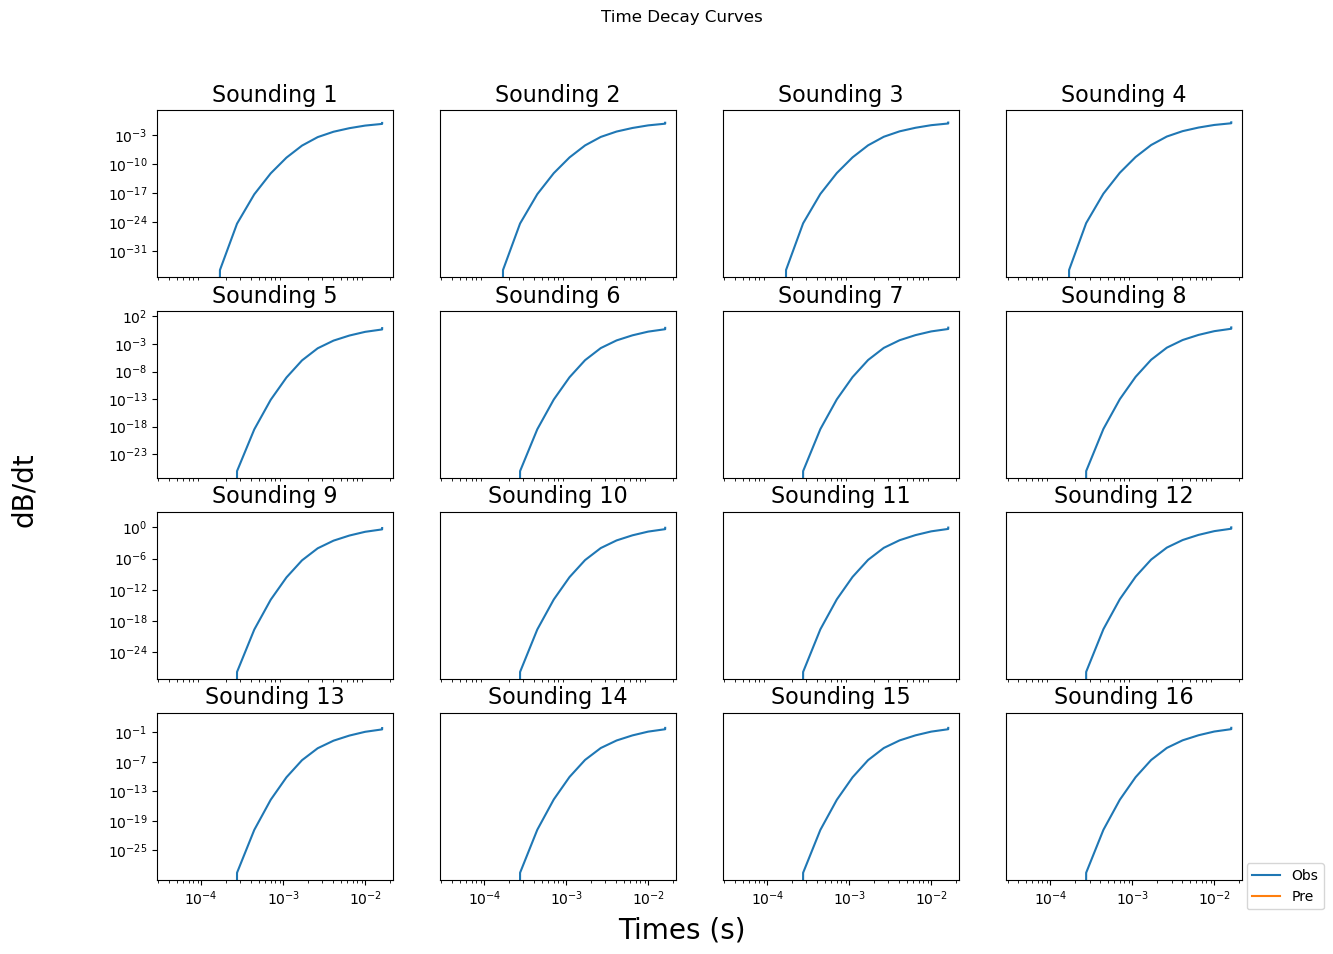

In [24]:
network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)

In [25]:
# something weird here
network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch,weighted=False)

tanhs (16, 32, 1)
nb 16
ys_test (16,)
tf.Tensor(
[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan 

In [26]:
plt.close('all')
plt.clf()
gc.collect()

22785

<Figure size 640x480 with 0 Axes>

# Load networks

In [27]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [28]:
loss_terms = np.load(run+'/losses.npy')

In [29]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [30]:
plt.rcParams.update({'font.size': 18})

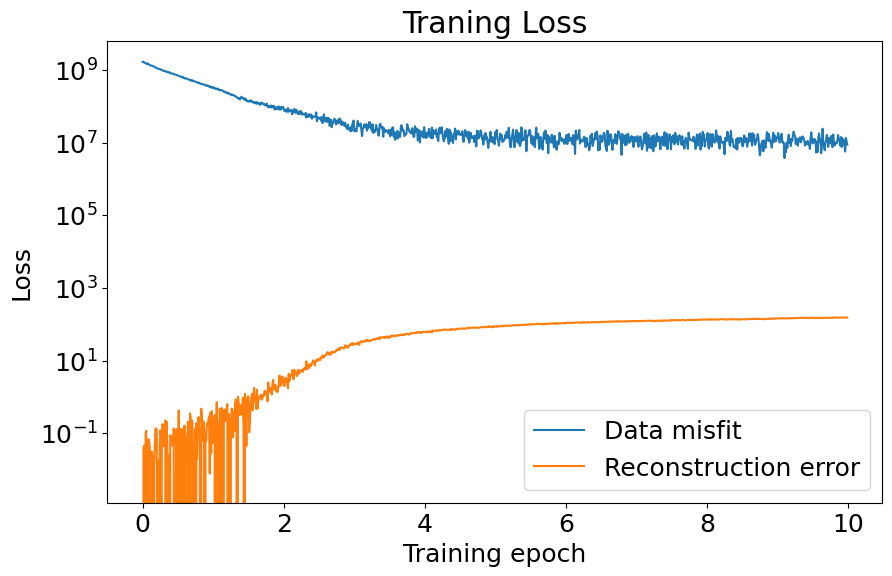

In [31]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt)
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title("Traning Loss")
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

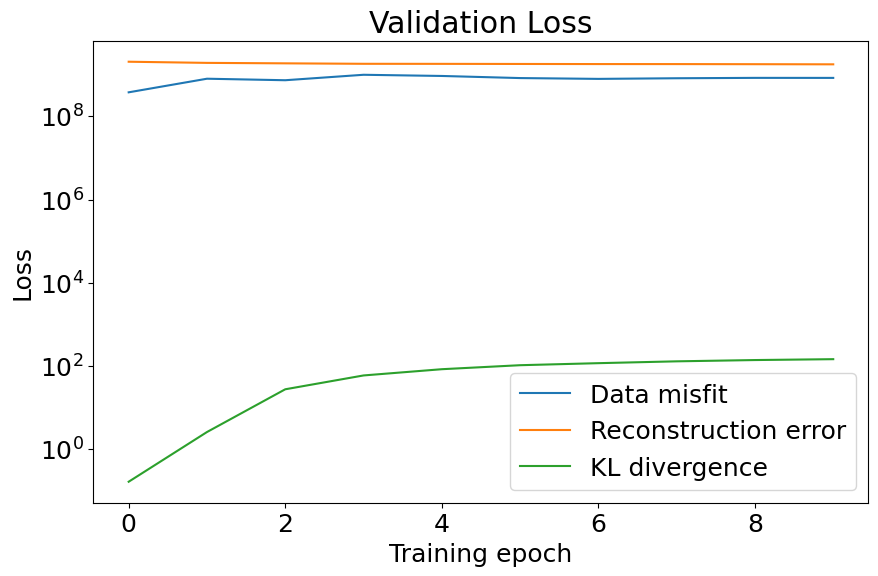

In [32]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title('Validation Loss')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

In [33]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths, step=16, save2file=True)

In [34]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = raw_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
print(zmd)
network.plot_models(latent=zmd)

tf.Tensor(
[[ 2.5517716   3.5502768   0.52110994  1.3874505  -3.8016233  -3.4989512
   4.3754296   0.99137455  6.1121507  -2.1406615  -1.7850178  -0.72845453
   4.7031097   0.80205435 -2.8495917   0.3523388   6.020821   -1.8677814
  -0.7360126   3.3256726   6.521849    6.130787    5.864043    5.613421
   5.318039    4.961664    4.545612    4.092835    3.604113    3.080189
   2.519379    1.935746    1.363487    0.840039    0.343572    0.343572  ]
 [ 2.5146942   3.6641011   0.5544646   1.5625851  -3.7689087  -3.5335052
   4.3015823   0.97815275  5.998998   -2.2494667  -1.6798949  -0.8505355
   4.697384    0.74588424 -2.9226582   0.23874426  6.056926   -1.8689715
  -0.7559705   3.3081112   6.481231    6.094156    5.830812    5.580077
   5.286391    4.932904    4.518857    4.06825     3.58176     3.060233
   2.502457    1.922282    1.354276    0.834088    0.341209    0.341209  ]
 [ 2.5743802   3.6612096   0.5383626   1.4444268  -3.7477252  -3.6013274
   4.2636137   0.9548256   6.0006733  -

In [35]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [36]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)

tanhs (16, 32, 1)


(<tf.Tensor: shape=(), dtype=float32, numpy=-0.764259>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.2718902>)

In [37]:
minmax(x_test1[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.5399266299885006>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.03254183984457575>)

tanhs (16, 32, 1)
nb 16
ys_test (16,)
data [[[-6.79834351e+02 -3.31603546e+02]
  [-4.59797821e+02 -1.64929413e+02]
  [-3.52145081e+02 -1.10050392e+02]
  [-2.74080261e+02 -8.51958466e+01]
  [-2.03983459e+02 -7.57176895e+01]
  [-1.42831299e+02 -6.93969879e+01]
  [-9.42180557e+01 -6.03988800e+01]
  [-5.99094925e+01 -4.79864807e+01]
  [-3.67490768e+01 -3.34905434e+01]
  [-2.17625141e+01 -1.96371136e+01]
  [-1.24208794e+01 -9.28147602e+00]
  [-6.92921114e+00 -3.47317839e+00]
  [-3.90980315e+00 -1.02467513e+00]
  [-2.31645727e+00 -2.37212300e-01]
  [-1.40997505e+00 -3.58923599e-02]
  [-1.40997505e+00 -3.58923599e-02]]

 [[-6.52774170e+02 -3.34384521e+02]
  [-4.43259674e+02 -1.62233353e+02]
  [-3.40635162e+02 -1.06151802e+02]
  [-2.65092072e+02 -8.09960938e+01]
  [-1.97628845e+02 -7.17576675e+01]
  [-1.38781921e+02 -6.60219193e+01]
  [-9.17306900e+01 -5.79824791e+01]
  [-5.84545860e+01 -4.67580223e+01]
  [-3.59367294e+01 -3.33200378e+01]
  [-2.13325291e+01 -2.00495205e+01]
  [-1.22124615e+01 

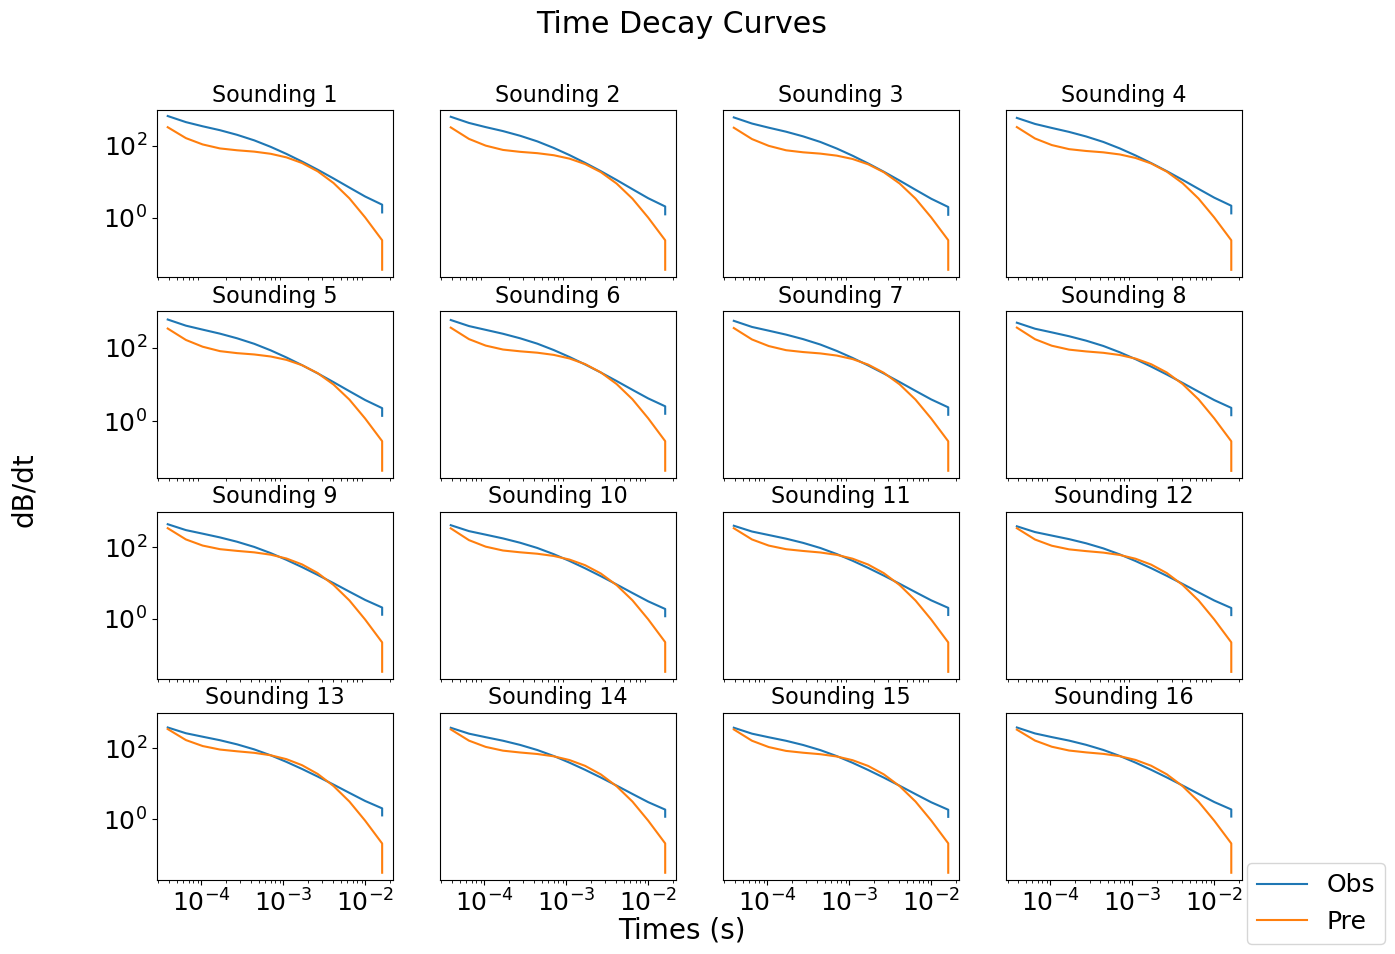

In [38]:
network.plot_data(latent=zmd)

tanhs (16, 32, 1)
nb 16
ys_test (16,)
tf.Tensor(
[[-171.0602     -115.91444     -90.809265    -81.03573     -74.35865
   -64.94449     -52.079315    -37.094658    -22.717302    -11.800855
    -5.408924     -2.3881621    -1.0772513    -0.37946436   -0.37946436]
 [-168.32751    -111.98261     -86.57617     -77.04406     -70.95483
   -62.501335    -50.82627     -36.9018      -23.109753    -12.255671
    -5.681017     -2.4983473    -1.1084149    -0.38412985   -0.38412985]
 [-167.7005     -111.50906     -85.54489     -75.753525    -69.81505
   -61.68361     -50.411587    -36.855347    -23.27327     -12.438623
    -5.7844906    -2.5324793    -1.1132684    -0.38339475   -0.38339475]
 [-169.3412     -113.372574    -88.53665     -79.08184     -72.666824
   -63.68274     -51.37492     -36.898132    -22.814365    -11.950518
    -5.4924426    -2.4112468    -1.0738785    -0.3746515    -0.3746515 ]
 [-167.78821    -111.62001     -85.75613     -75.98541     -70.00489
   -61.806335    -50.445328    -3

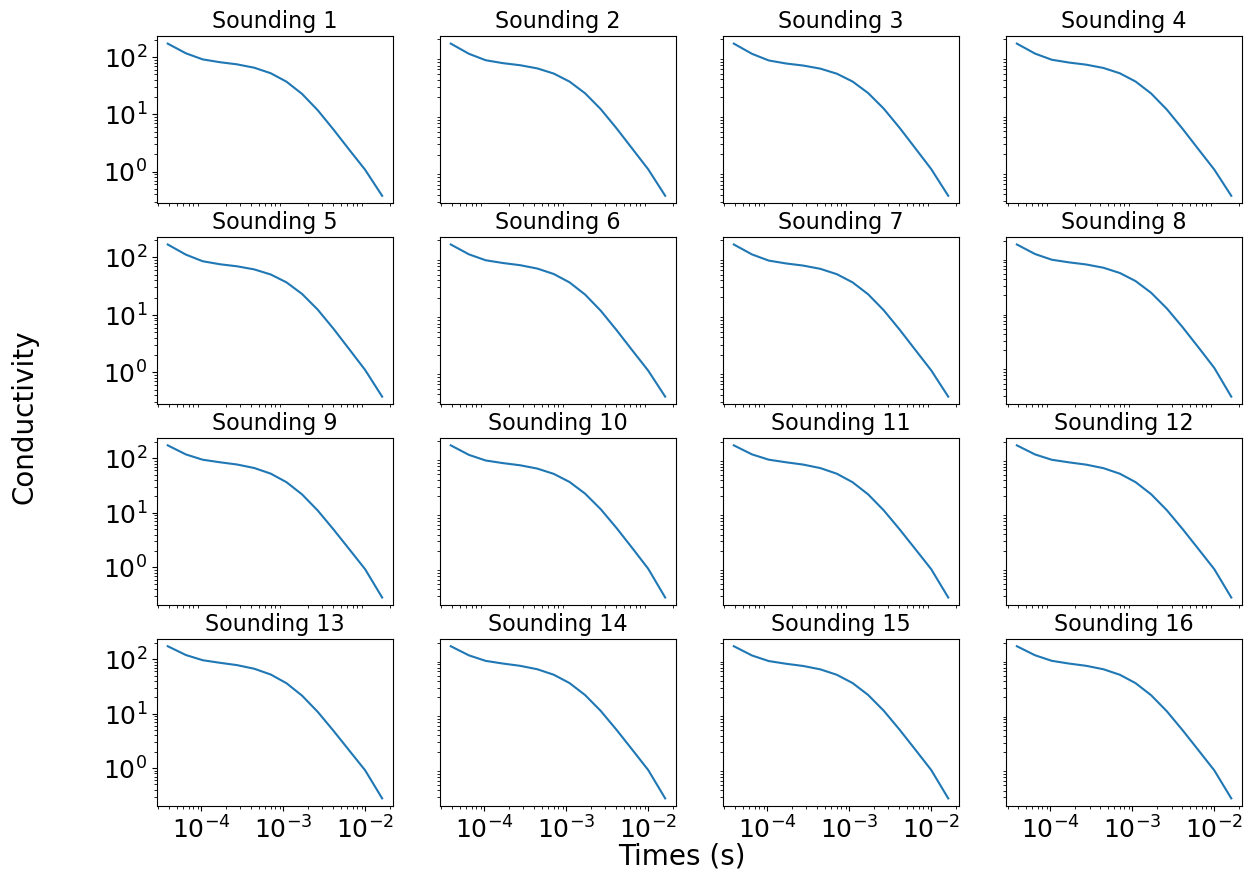

In [39]:
network.plot_residuals(latent=zmd, weighted=False)

# Randomize latent; does data still fit?

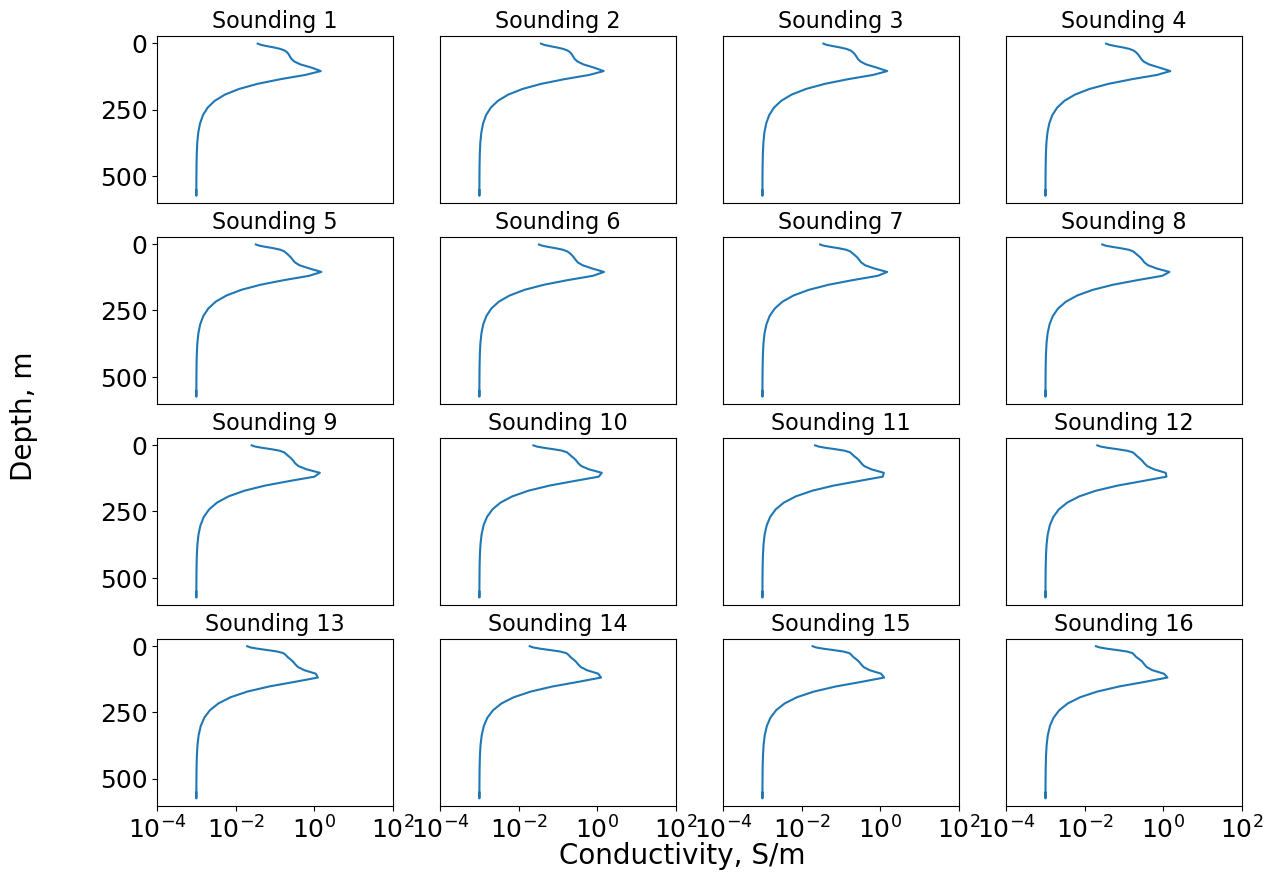

In [56]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test1[0:16])), depths=depths)

In [41]:
print(x_test1[0:1].shape)

(1, 32, 1)


In [42]:
data0 = tf.tile(z_data[0:1],[16,1])
print(latent_input)
data0 = tf.cast(data0, tf.float32)
print(data0)
zmd2 = tf.concat((latent_input,data0),-1)

tf.Tensor(
[[-0.3991576   2.1044393   0.17107224  0.54651815 -2.4234028   0.422554
   0.28943786 -0.5043041  -0.96068907 -0.65109813  0.11453361 -0.10354779
  -1.300912   -0.5038757   0.02013604 -0.09342099 -0.12571211 -0.04320283
  -0.46242726  0.5460443 ]
 [-0.3929454   2.5214329  -1.4561468   0.903801   -0.26212615  0.6240329
  -0.2521848   0.7573418  -0.8864083   1.3231359  -1.198264    0.7606799
   0.84330815  0.2508936   0.2366665  -1.8962964  -1.4281125  -0.53130555
   0.2552794  -0.93993634]
 [-1.5221636  -0.00822365 -0.99627084  2.2360663  -1.2033943  -0.7806828
   0.06733078 -0.09443122 -0.79472643 -1.0500034   1.8989234  -0.01403297
  -0.34101093  0.41645935 -0.8555833  -1.7821804  -0.8367842  -0.4198522
   1.1202166   0.1578002 ]
 [-0.9718228  -1.1949148  -0.7339681   2.6671498   0.31153223 -1.7295812
   0.7310225   0.5419145   1.1466506  -0.8392687   0.21369308 -0.5510486
  -0.475889    0.10139231 -0.6165251  -0.75944835 -0.90987056 -0.10693633
  -0.44400555 -0.30344325]
 

In [43]:
network.plot_models(latent=zmd2)

latent (16, 36)
tanhs (16, 32, 1)
tanhs (16, 32, 1)


In [44]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = np.exp(network.tanhs_to_model(zmd2_tanhs))

tanhs (16, 32, 1)


In [45]:
zmd2_logs.shape

(16, 32)

In [46]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

In [47]:
# print(zmd2_logs)
mean_cond = np.mean((zmd2_logs),axis=0)
std_cond = np.std((zmd2_logs),axis=0)
uncertainty = np.mean(mean_cond+std_cond**2)
print(uncertainty)
# plt.semilogx(mean_cond, plot_depths)
# plt.invert_yaxis()

2.3637598


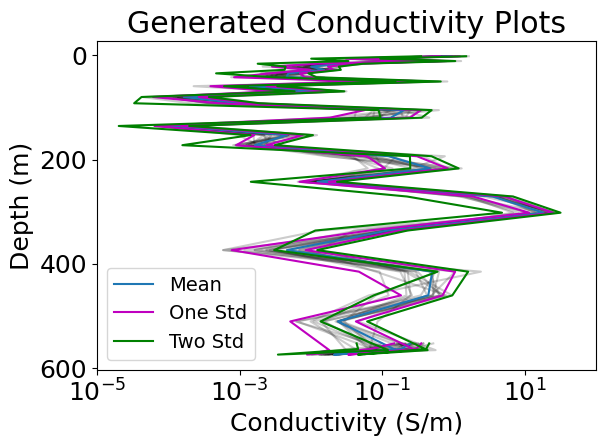

In [59]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond),plot_depths, c='m', label="One Std")
ax.semilogx(np.abs(mean_cond-std_cond), plot_depths, c='m')
ax.semilogx(np.abs(mean_cond+2*std_cond), plot_depths, c='g', label= 'Two Std') # type: ignore
ax.semilogx(np.abs(mean_cond-2*std_cond), plot_depths, c='g')
# ax.semilogx(mean_cond+std_cond**2, plot_depths)
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(1e-5, 1e2)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots_mean&2std.jpg')
plt.show()

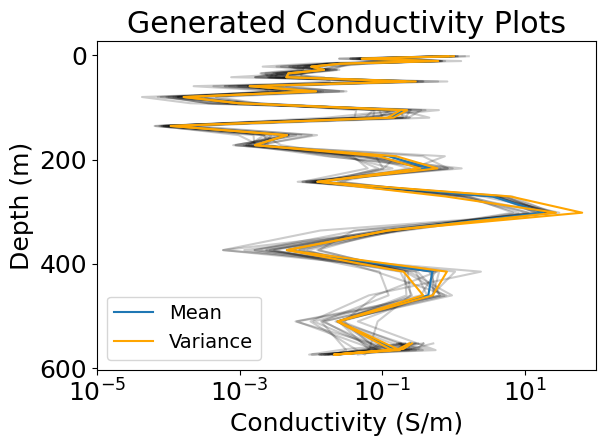

In [58]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond**2), plot_depths, c='orange', label='Variance')
ax.semilogx(np.abs(mean_cond-std_cond**2), plot_depths, c='orange')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(1e-5, 1e2)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

tanhs (16, 32, 1)
nb 16
ys_test (16,)
data [[[-6.79834351e+02 -4.33986572e+02]
  [-4.59797821e+02 -2.76731750e+02]
  [-3.52145081e+02 -2.40333405e+02]
  [-2.74080261e+02 -2.11905930e+02]
  [-2.03983459e+02 -1.75093674e+02]
  [-1.42831299e+02 -1.28568344e+02]
  [-9.42180557e+01 -7.92733536e+01]
  [-5.99094925e+01 -4.11944427e+01]
  [-3.67490768e+01 -1.82385445e+01]
  [-2.17625141e+01 -6.89045334e+00]
  [-1.24208794e+01 -2.23016095e+00]
  [-6.92921114e+00 -6.22850060e-01]
  [-3.90980315e+00 -1.51680455e-01]
  [-2.31645727e+00 -3.90371382e-02]
  [-1.40997505e+00 -1.72314290e-02]
  [-1.40997505e+00 -1.72314290e-02]]

 [[-6.79834351e+02 -3.09928284e+02]
  [-4.59797821e+02 -1.86427521e+02]
  [-3.52145081e+02 -1.46023453e+02]
  [-2.74080261e+02 -1.25646683e+02]
  [-2.03983459e+02 -1.12266563e+02]
  [-1.42831299e+02 -9.71130219e+01]
  [-9.42180557e+01 -7.60662613e+01]
  [-5.99094925e+01 -5.21822662e+01]
  [-3.67490768e+01 -3.06018028e+01]
  [-2.17625141e+01 -1.49440269e+01]
  [-1.24208794e+01 

c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py:605: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(*ylims)


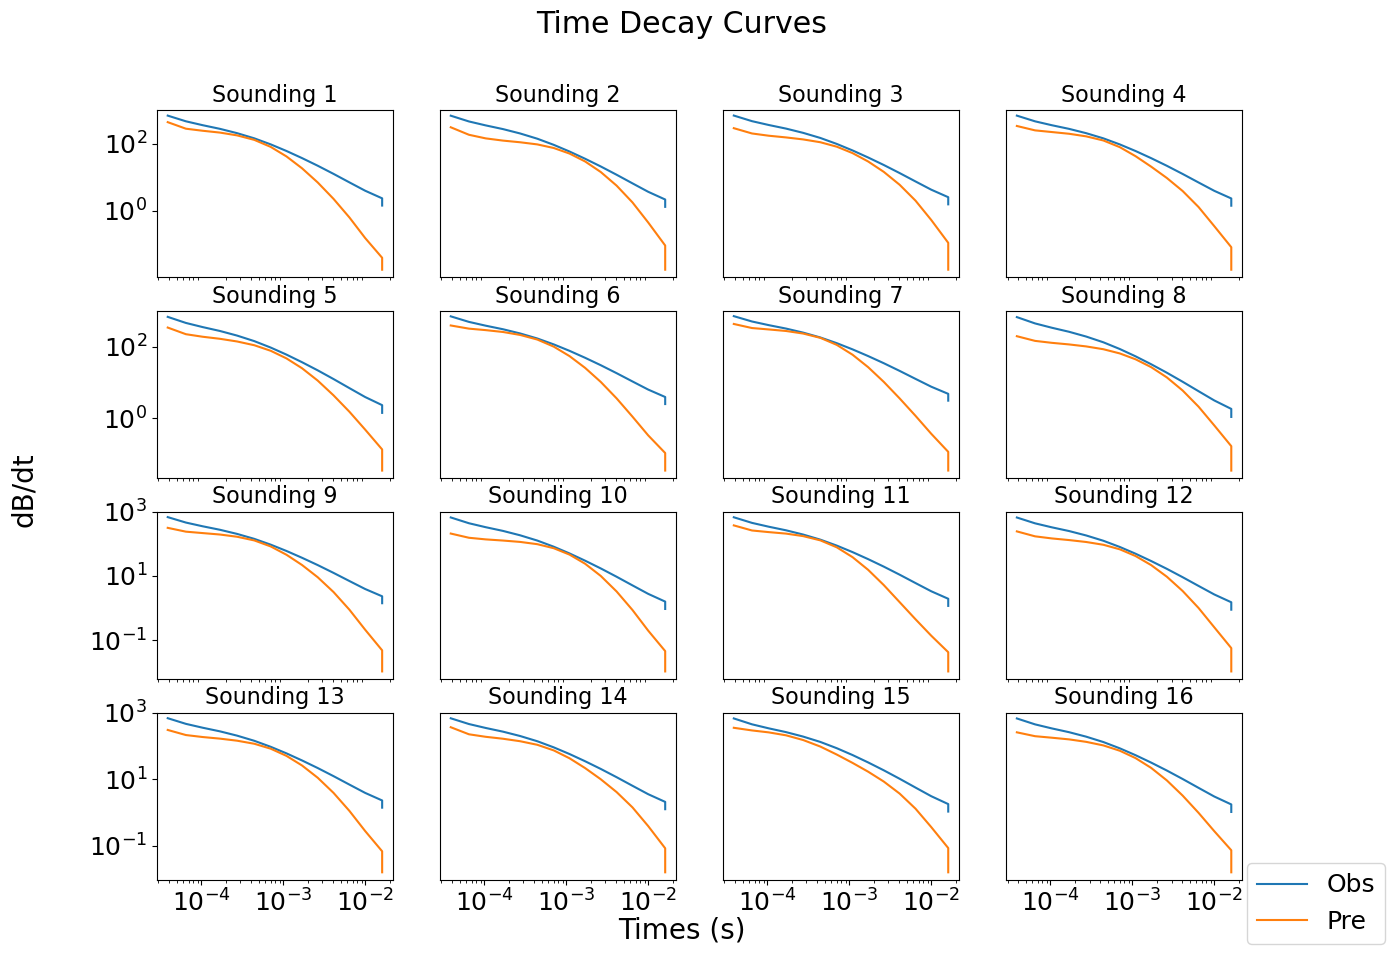

In [50]:
network.plot_data(latent=zmd2)

In [51]:
#log_data_test[0]

In [52]:
-tf.exp(zmd2[0, 50:])

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [53]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

In [54]:
network.plot_residuals(latent=zmd2, weighted=True)

tanhs (16, 32, 1)
nb 16
ys_test (16,)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [16,16] vs. [1,32] [Op:Mul] name: 

In [706]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


array([3.1499999, 0.6      ], dtype=float32)

In [707]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

(3.15, 0.6)

In [708]:
network.data_weights

array([[[5.48595234e+02],
        [6.64350638e+02],
        [1.01762084e+03],
        [2.13942172e+03],
        [6.29904544e+03],
        [1.73081025e+04],
        [1.88571551e+04],
        [1.25243956e+04],
        [1.16432945e+04],
        [2.35853466e+04],
        [3.57238109e+05],
        [1.90076739e+06],
        [1.22610847e+04],
        [1.76403655e+03],
        [6.37863586e+02],
        [3.46907159e+02],
        [2.34253210e+02],
        [1.80179363e+02],
        [1.50882595e+02],
        [1.33918997e+02],
        [1.23786746e+02],
        [1.17700540e+02],
        [1.14096509e+02],
        [1.12024355e+02],
        [1.10881603e+02],
        [1.10282769e+02],
        [1.09986440e+02],
        [1.09848638e+02],
        [1.09789471e+02],
        [1.09770243e+02],
        [1.09783744e+02],
        [1.09777411e+02]]])

In [709]:
print(cond2[0])
print(cond2[1])

[3.648398e-02 4.375333e-02 6.125686e-02 9.333318e-02 1.370639e-01
 1.768252e-01 2.043877e-01 2.243076e-01 2.409013e-01 2.620672e-01
 3.102367e-01 4.454715e-01 8.480549e-01 1.465697e+00 5.938051e-01
 1.385875e-01 3.616845e-02 1.220992e-02 5.347820e-03 2.938946e-03
 1.941052e-03 1.475557e-03 1.242081e-03 1.121129e-03 1.058532e-03
 1.026996e-03 1.011817e-03 1.004928e-03 1.002029e-03 1.001002e-03]
[3.692505e-02 4.404815e-02 6.117529e-02 9.257349e-02 1.356392e-01
 1.754015e-01 2.036590e-01 2.246761e-01 2.426639e-01 2.649555e-01
 3.129994e-01 4.433329e-01 8.184385e-01 1.454583e+00 6.258761e-01
 1.456389e-01 3.750132e-02 1.251276e-02 5.433118e-03 2.967756e-03
 1.952150e-03 1.480173e-03 1.244037e-03 1.121919e-03 1.058802e-03
 1.027046e-03 1.011785e-03 1.004876e-03 1.001975e-03 1.000939e-03]


In [710]:
# num_plots = 4
# fig = plt.figure(figsize=(8, 10))
# for i in range(0, num_plots):
#     ax = plt.subplot(int(num_plots),2,i+1)
#     ax.plot(times, -obs2[i], -pred2[i])
#     plt.xlabel('Time (s)')
#     plt.ylabel('dB/dt')
#     plt.legend(['Observed','Predicted'])
# plt.tight_layout()
# plt.savefig('Raw_Time_Decay_Curves_Line2_Central.jpg')

In [711]:
# print(len(cond2))

In [71]:
# depths1 = np.append(depths,[652])
# fig, ax = plt.subplots()
# ax.semilogx(cond2[0], depths1, c='k', alpha=0.2)
# ax.semilogx(cond1[0], depths1, c='k',alpha=0.2)
# ax.invert_yaxis()
# # ax.axes.set_xlim(1e-2, 1e4)
# plt.xlabel('Conductivity')
# plt.ylabel('Depth')
# plt.tight_layout()
# plt.savefig('Raw_ConductivityvsDepth_Line2_Central.jpg')
# plt.show()